In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax
from time import time
from pymatching import Matching

from core.quantum_error_correction_code import SurfaceCode, deformation_cmap
from core.neural_network import CNNDual, save_params
from core.perfect_maximum_likelihood_decoder import PMLD

In [3]:
BATCH_SIZE = 16
GENERAL_TRAINING_BATCHES = 1_000_000
FINETUNING_TRAINING_BATCHES = 250_000

CODE_DISTANCE = 5

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 2_000
TRANSITION_STEP = 20_000
DECAY_RATE = 0.95

# Number of filters, Kernal size, Stride
NUM_FILTERS = CODE_DISTANCE**2-1
# NUM_FILTERS = int(2**jnp.ceil(jnp.log2(CODE_DISTANCE**2-1)))
CONV_LAYERS_INPUT_1 = [(NUM_FILTERS,2,1,0)]
CONV_LAYERS_INPUT_2 = [(NUM_FILTERS,1,1,0)]
CONV_LAYERS_STAGE_2 = [(NUM_FILTERS,3,1,0)]
FC_LAYERS = [50, 2]
print(f"{NUM_FILTERS = }")

SEED = 16

DEFORMATION_OPTIONS = jnp.array([0,1,2,3,4,5])
# DEFORMATION_OPTIONS = jnp.array([0,2,3])

p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
# ERROR_PROBS = jnp.array([.01,.01,.01])

settings = {
    "CODE_DISTANCE": CODE_DISTANCE,
    "DEFORMATION_OPTIONS": DEFORMATION_OPTIONS,
    "ERROR_PROBS": ERROR_PROBS,
    "CONV_LAYERS_INPUT_1": CONV_LAYERS_INPUT_1,
    "CONV_LAYERS_INPUT_2": CONV_LAYERS_INPUT_2,
    "CONV_LAYERS_STAGE_2": CONV_LAYERS_STAGE_2,
    "FC_LAYERS": FC_LAYERS,
}

NUM_FILTERS = 24


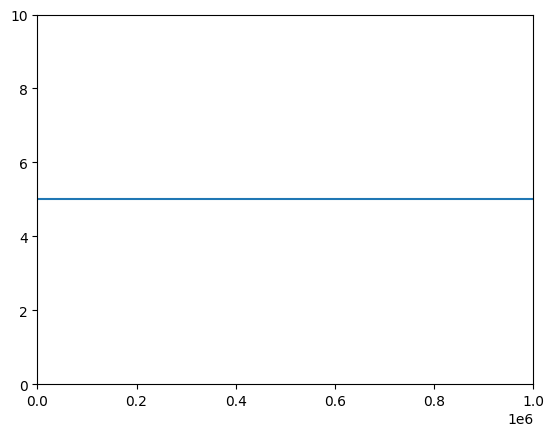

In [4]:
# p_init, p_target, p_decay_rate = 10, 1, 200_000

# scaling = lambda step: (p_init-p_target)*jnp.exp(-step/p_decay_rate) + p_target
# scaling = optax.cosine_decay_schedule(
#     init_value=10,
#     decay_steps=GENERAL_TRAINING_BATCHES // 2,
#     alpha=.1
# )
scaling = lambda x: x*0+5

x = jnp.linspace(0, GENERAL_TRAINING_BATCHES, 1_000)
y = scaling(x)

plt.figure()
plt.plot(x,y)
plt.ylim(0, 10)
plt.xlim(0, GENERAL_TRAINING_BATCHES)
plt.show()

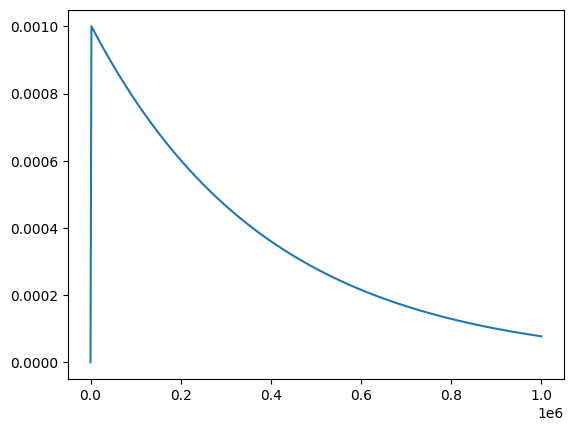

In [5]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, GENERAL_TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.show()

optimizer = optax.adam(learning_rate)

In [6]:
def sample_deformation(
    key, 
    probs: jnp.ndarray
):
    """
    Samples a specific deformation based on a probability distribution on each data qubit.

    probs: Matrix of shape (6,*shape) with axis 0 summing to 1 in all cases

    return: Deformation array of size prod(*shape)
    """
    return _sample_deformation(key, probs)

@jit
def _sample_deformation(
    key, 
    probs: jnp.ndarray
):
    keys = random.split(key, num=probs.shape[1]*probs.shape[2])
    return vmap(
        lambda k, p: random.choice(k, jnp.arange(6), p=p), 
        in_axes=(0, 1)
    )(
        keys, probs.reshape(6, -1)
    )

In [7]:
def train(
    random_seed: int,
    code: SurfaceCode,
    probabilities: jnp.ndarray,
    prob_scaling_fun: callable,
    optimizer: optax.GradientTransformation,
    model: CNNDual
):
    @jit
    def loss_fn(
        model_params,
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN and perform a weighted avarage
        """
        probs = nn.softmax(model_params["deformation_dist"], axis=0)
        used_probs = probs.reshape(6,-1)[deformations, jnp.arange(code.num_data_qubits)]
        error_locations = jnp.logical_or(errors[:,0,:], errors[:,1,:])
        # Add a small number to the sum in case it is zero to avoid returning NAN
        weights = jnp.sum(used_probs*error_locations, axis=1) / (error_locations.sum(axis=1) + 1E-20)
        idv_loss = optax.sigmoid_binary_cross_entropy(
            logits=model.apply_batch(model_params, x1, x2),
            labels=y
        ).mean(axis=1)
        # Add a small number to weights in case they are all zero to avoid returning NAN
        return jnp.average(idv_loss, weights=weights + 1E-20)

    @jit
    def update(
        model_params, 
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, deformations, errors, x1, x2, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
        deformations: jnp.ndarray,
        step: int,
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        parity_infos = vmap(
            code.deformation_parity_info
        )(deformations)
        errors = vmap(
            code.error,
            in_axes=(0, None),
        )(data_key[:-1], probabilities*prob_scaling_fun(step))
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, 0),
        )(errors, parity_infos)
        return imgs[:,None,:,:], logicals, errors, data_key[-1]

    @jit
    def sampled_deformations(
        deformation_key,
        probs: jnp.ndarray,
    ):
        deformation_keys = random.split(deformation_key, num=BATCH_SIZE+1)
        deformations = vmap(
            sample_deformation, 
            in_axes=(0, None)
        )(deformation_keys[1:], probs)
        return deformations, deformation_keys[0]
    
    @jit
    def likeliest_deformations(
        deformation_key,
        probs: jnp.ndarray,
    ):
        # Same deformation for all batches
        deformation = probs.argmax(axis=0).flatten()
        deformations = jnp.tile(deformation, reps=(BATCH_SIZE, 1))
        return deformations, deformation_key

    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        ) = val

        probs = nn.softmax(model_params["deformation_dist"], axis=0)
        # deformations shape=(BATCH_SIZE, NUM_DATA_QUBITS)
        (deformations, deformation_key) = lax.cond(
            i > GENERAL_TRAINING_BATCHES,
            lambda args: likeliest_deformations(*args),
            lambda args: sampled_deformations(*args),
            operand=(deformation_key, probs)
        )
        # deformation_images shape=(BATCH_SIZE, 6, CODE_DISTANCE, CODE_DISTANCE)
        deformation_images = vmap(code.deformation_image)(deformations)

        # syndrome_images shape=(BATCH_SIZE, 1, CODE_DISTANCE+1, CODE_DISTANCE+1)
        # logicals shape=(BATCH_SIZE, 2)
        syndrome_images, logicals, errors, data_key = get_data(
            data_key,
            deformations,
            step=i,
        )
        loss, model_params, opt_state = update(
            model_params,
            deformations,
            errors,
            syndrome_images,
            deformation_images,
            logicals,
            opt_state,
        )
        losses = losses.at[i].set(loss)

        return (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        )
    
    init_key, data_key, deformation_key = random.split(
        key = random.key(random_seed),
        num=3
    )
    num_itr = GENERAL_TRAINING_BATCHES + FINETUNING_TRAINING_BATCHES

    model_params = model.init(init_key)
    model_params["deformation_dist"] = jnp.zeros(
        shape=(6, CODE_DISTANCE, CODE_DISTANCE),
        dtype=jnp.float32
    )
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=num_itr, dtype=jnp.float32)

    val_init = (
        model_params,
        optimizer_state,
        data_key,
        deformation_key,
        losses,
    )

    vals = lax.fori_loop(0, num_itr, _fori_body, val_init)

    return vals

In [8]:
code = SurfaceCode(L=CODE_DISTANCE)
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
for name, layer_sizes in model.layer_sizes.items():
    print(name, layer_sizes)

t0 = time()

(
    model_params,
    opt_state,
    data_key,
    deformation_key,
    losses,
) = train(
    random_seed=SEED,
    code=code,
    probabilities=ERROR_PROBS,
    prob_scaling_fun=scaling,
    optimizer=optimizer,
    model=model
)

print(losses[-1])

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

CNN_input_1 [(1, 6, 6), (24, 5, 5)]
CNN_input_2 [(6, 5, 5), (24, 5, 5)]
CNN_stage_2 [(24, 5, 5), (24, 3, 3)]
MLP_stage_3 [216, 50, 2]
0.0001267968


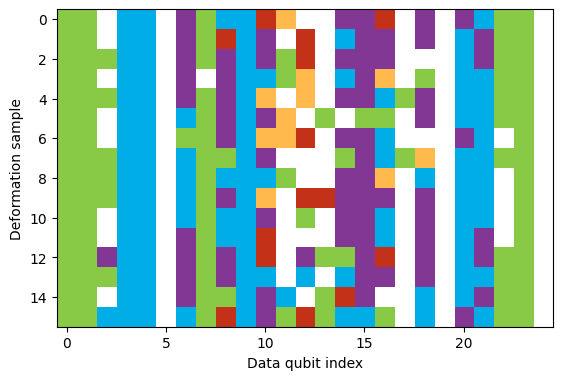

In [9]:
probs = nn.softmax(model_params["deformation_dist"], axis=0)
keys = random.split(random.key(61), num=BATCH_SIZE)
deformations = vmap(sample_deformation, in_axes=(0, None))(keys, probs)

plt.figure()
plt.imshow(deformations, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
# plt.imshow(jnp.array([0,0,2,3,3,2])[deformations], interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.xlabel("Data qubit index")
plt.ylabel("Deformation sample")
plt.show()

/tmp/ipykernel_697191/4136589115.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()])


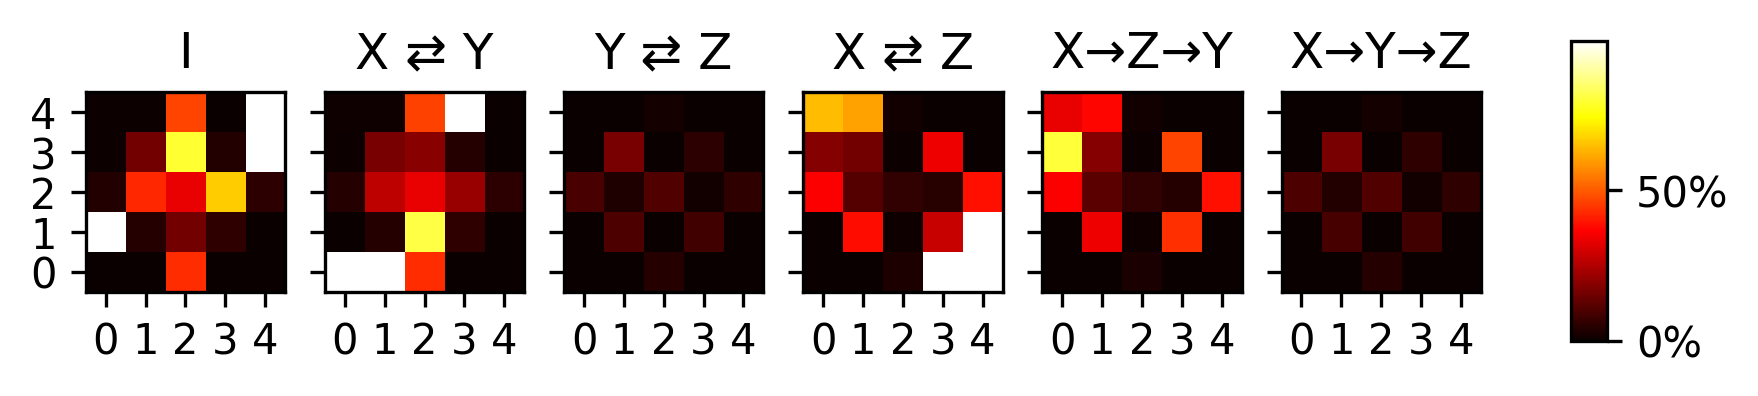

In [10]:
fig, axs = plt.subplots(ncols=6, figsize=(6,1), sharey=True, dpi=300)
probs = nn.softmax(model_params["deformation_dist"], axis=0)
for i in range(6):
    im = axs[i].imshow(
        probs[i], 
        origin='lower',
        cmap='hot',
        vmin=0,
        vmax=probs.max(),
    )
    axs[i].set_title([
        "I",
        "X ⇄ Y",
        "Y ⇄ Z",
        "X ⇄ Z",
        "X→Z→Y",
        "X→Y→Z",
    ][i], rotation=0)
    axs[i].set_xticks(jnp.arange(CODE_DISTANCE))
    axs[i].set_yticks(jnp.arange(CODE_DISTANCE))
cax = fig.add_axes((.95,0,.02,1))
cb = plt.colorbar(im, cax=cax)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()])
plt.show()

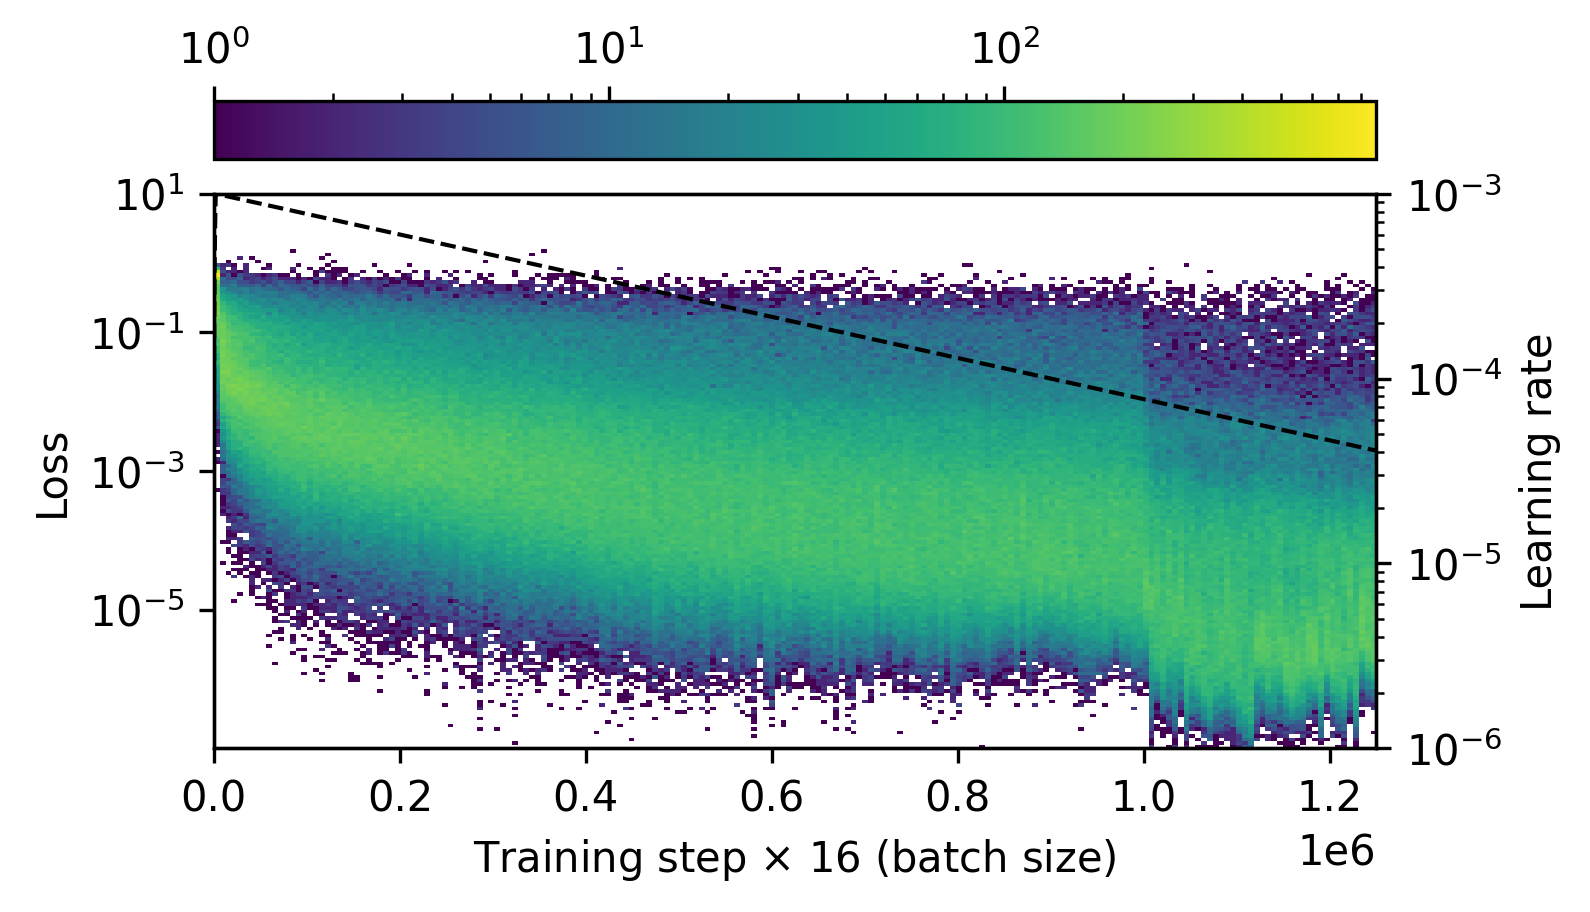

In [11]:
y_max = jnp.ceil(jnp.log10(losses).max()).astype(jnp.int32)
y_min = jnp.floor(jnp.log10(jnp.percentile(losses, .05))).astype(jnp.int32)
step = jnp.arange(losses.shape[0])
plt.figure(dpi=300, figsize=(5,3))
plt.hist2d(
    x=step, 
    y=losses, 
    bins=[
        jnp.linspace(0, losses.shape[0], 200),
        jnp.logspace(y_min, y_max, (y_max-y_min)*20+1)
    ],
    norm=LogNorm(vmin=1),
)
# plt.plot(step, losses, ',', alpha=.5)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel(f"Training step $\\times$ {BATCH_SIZE} (batch size)")
plt.colorbar(location="top")

plt.twinx()
plt.plot(step, learning_rate(step), '--k', lw=1)
plt.yscale('log')
plt.ylabel("Learning rate")
plt.ylim(1E-6, 1E-3)

plt.xlim(0, losses.shape[0])

plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}.eps", bbox_inches='tight')
plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}.png", bbox_inches='tight')

plt.show()

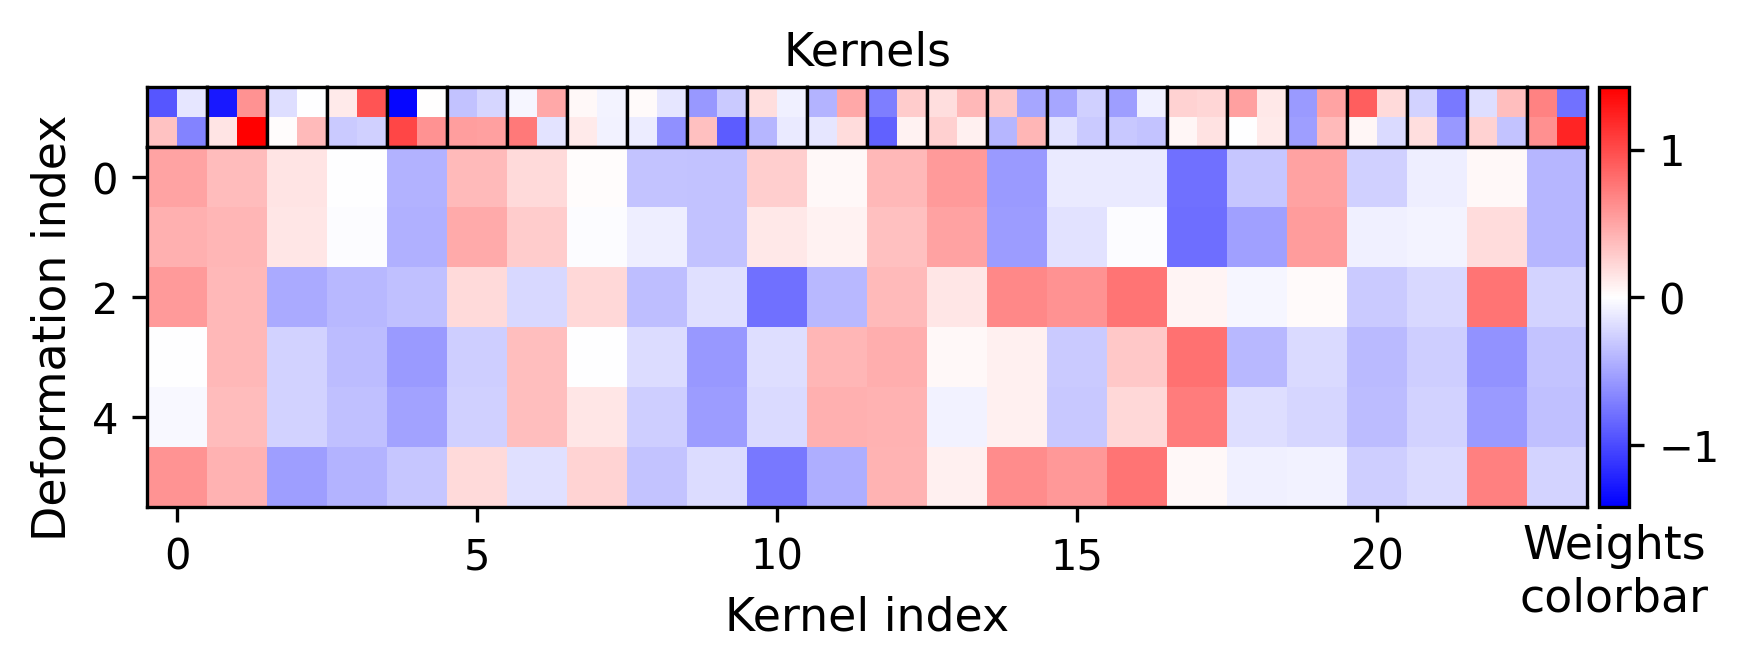

In [12]:
kernels = model_params['CNN_input_1'][0]['w']
mask = model_params['CNN_input_2'][0]['w'][:,:,0,0]
lims = jnp.abs(kernels).max()

fig_width = 5
fig = plt.figure(dpi=300, figsize=(
    fig_width / (kernels.shape[0]+1),
    fig_width / (kernels.shape[0]+1)
))
kernel_axs = [
    fig.add_axes((i,0,1,1))
    for i in range(kernels.shape[0])
]
mask_ax = fig.add_axes((0,-mask.shape[1],mask.shape[0],mask.shape[1]))
cax = fig.add_axes((mask.shape[0]+.2,-mask.shape[1],.5,mask.shape[1]+1))

for i, ax in enumerate(kernel_axs):
    im = ax.imshow(kernels[i,0], vmin=-lims, vmax=lims, cmap="bwr")
    # ax.set_title(f"{i}")
    ax.set_xticks([])
    ax.set_yticks([])
im = mask_ax.imshow(mask.T, vmin=-lims, vmax=lims, cmap="bwr")
mask_ax.set_xlabel("Kernel index", fontsize=11)
mask_ax.set_ylabel("Deformation index", fontsize=11)
mask_ax.set_title("Kernels", y=1.16, fontsize=11)
fig.colorbar(im, cax=cax)
cax.set_xlabel("Weights\ncolorbar", fontsize=11)

plt.savefig(f"figs/cnn_decoder_and_deformation_weights_map_on_distance{CODE_DISTANCE}.eps", bbox_inches='tight')
plt.savefig(f"figs/cnn_decoder_and_deformation_weights_map_on_distance{CODE_DISTANCE}.png", bbox_inches='tight')
plt.show()

In [13]:
save_params(model_params, settings, f"data/specific_distance{CODE_DISTANCE}_decoder.json")

# Compare to other decoders

In [14]:
data_key = random.key(42)
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

In [15]:
def get_data(
    data_key,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    print(errors.shape)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [16]:
subkey, data_key = random.split(data_key)
probs = nn.softmax(model_params["deformation_dist"], axis=0)
# deformation = sample_deformation(subkey, probs)
deformation = probs.argmax(axis=0).flatten()

# deformation = jnp.array([0,0,0,0,0,0,0,0,0])
# deformation = jnp.array([3,0,3,0,3,0,3,0,3])
# deformation = jnp.array([2,0,2,3,2,3,2,0,2])
# deformation = jnp.array([2,3,2,0,2,0,2,3,2])
# deformation = jnp.array([2,2,2,2,2,2,2,2,2])

parity_info = code.deformation_parity_info(deformation)
deformation_img = code.deformation_image(deformation)[None,:,:,:]
print(deformation.reshape(CODE_DISTANCE, CODE_DISTANCE))

[[1 1 0 3 3]
 [0 3 1 4 3]
 [3 0 1 0 4]
 [4 4 0 4 0]
 [3 3 0 1 0]]


In [17]:
imgs, syndromes, logicals, data_key = get_data(
    data_key, 
    batch_size=500_000, 
    parity_info=parity_info
)

(500000, 2, 25)


NN-model decoder

In [18]:
nn_logicals = (nn.sigmoid(
    model.apply_batch(model_params, imgs, deformation_img)
) > .5).astype(jnp.int32)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * nn_logicals[:, 0] + nn_logicals[:, 1]
nn_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

MWPM decoder

In [19]:
def deform_recovery_batch(
    recovery = jnp.ndarray,
):
    def _deform_recovery(
        recovery: jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[0, 1], [1, 1]],  # X-Y-Z
            [[1, 1], [1, 0]],  # X-Z-Y
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[deformation]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

# Decodes the un-deformed surface code and then deforms the recovery operation
matcher = Matching(
    jnp.append(code.hx_original, code.hz_original, axis=1)
)
recovery = matcher.decode_batch(syndromes)
recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
recovery = deform_recovery_batch(recovery)
mwpm_logicals = logicals_of_recovery(recovery, parity_info)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * mwpm_logicals[:, 0] + mwpm_logicals[:, 1]
mwpm_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

Perfect maximum likelihood decoder

In [20]:
# The PML decoder can't handle codes with a lot of qubits
if CODE_DISTANCE == 3:
    perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
    pml_logicals = perfect_decoder.decode_batch(syndromes)

    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * pml_logicals[:, 0] + pml_logicals[:, 1]
    pml_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)
else:
    pml_hist = jnp.zeros((4,4))

### Compare

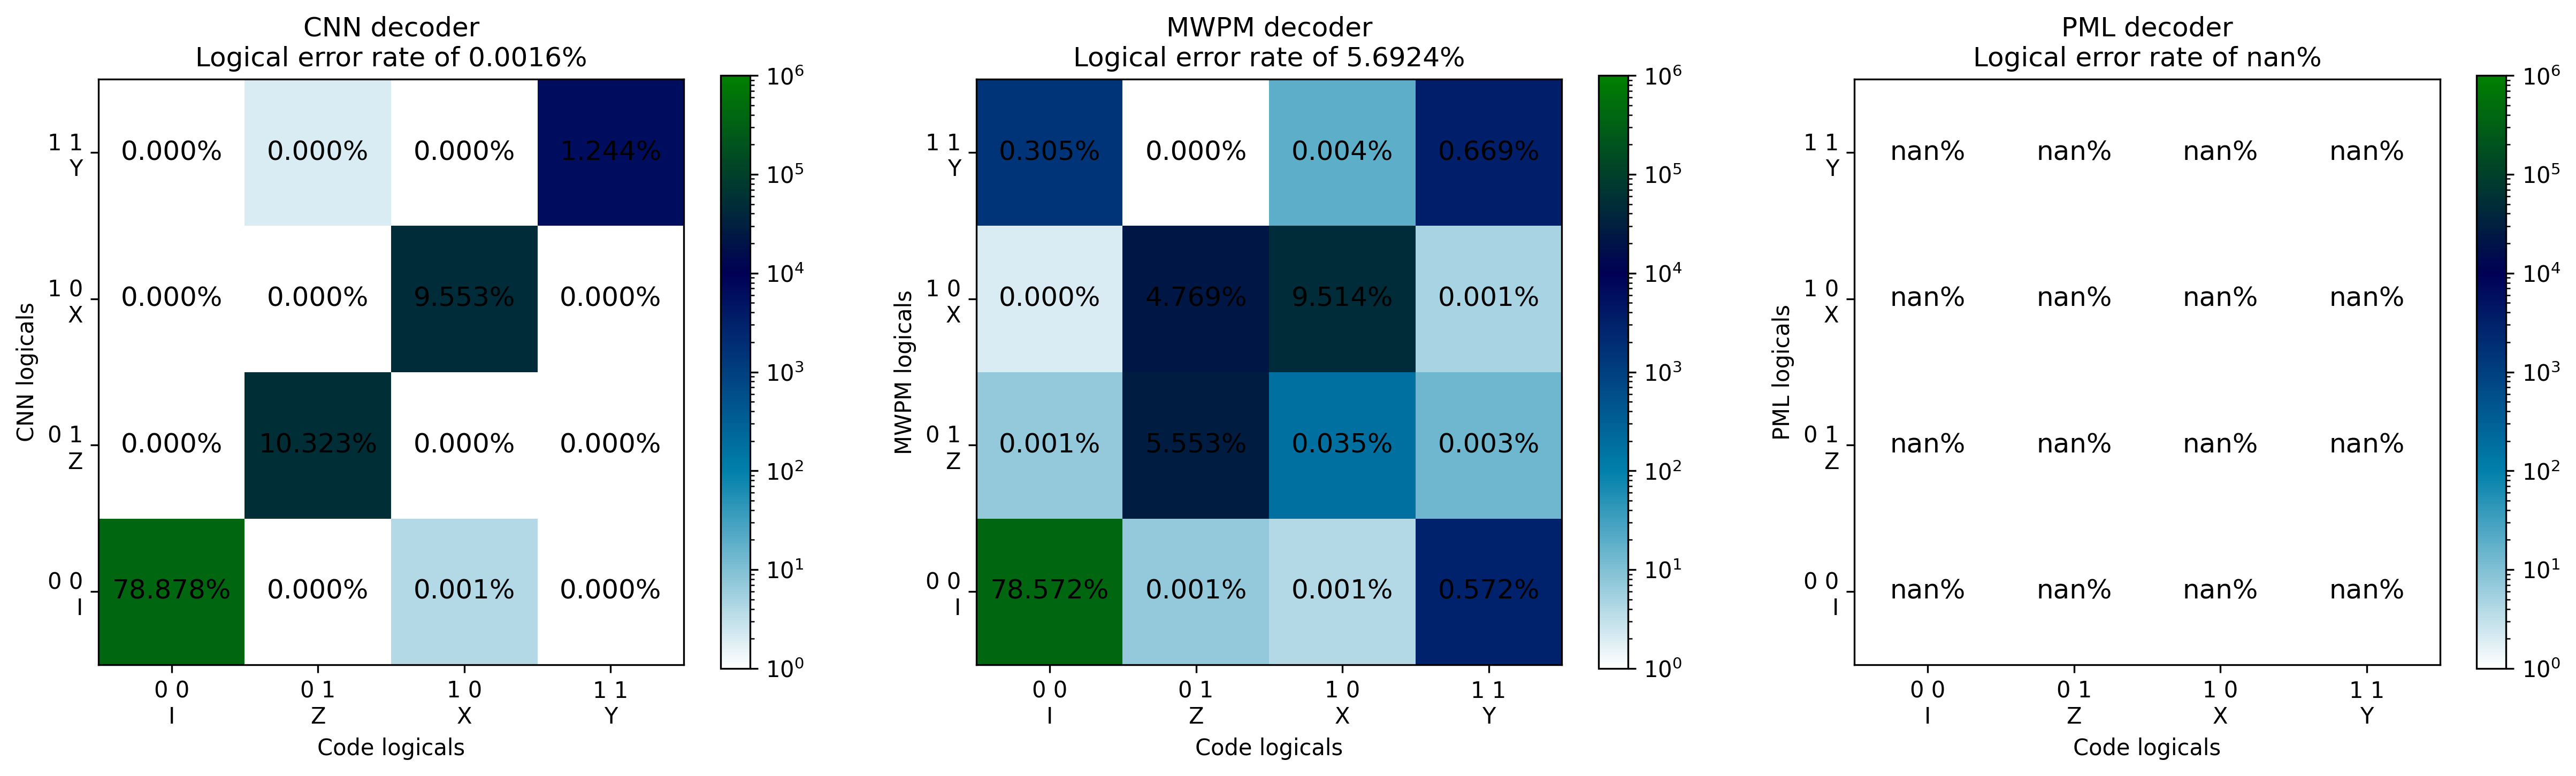

[1 1 0 3 3 0 3 1 4 3 3 0 1 0 4 4 4 0 4 0 3 3 0 1 0]


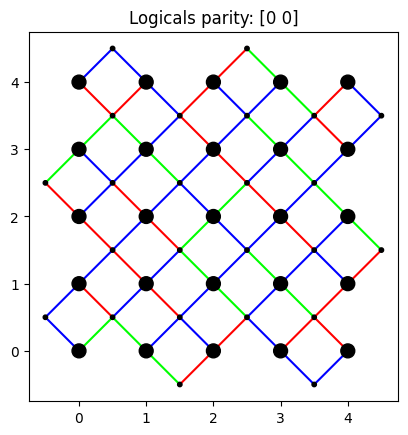

% Draw the plaquettes
\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\filldraw[fill=black!10, draw=none] (0,4) -- (2,4) -- (2,6) -- (0,6) -- cycle;
\filldraw[fill=black!5, draw=none] (0,6) -- (2,6) -- (2,8) -- (0,8) -- cycle;
\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;
\filldraw[fill=black!5, draw=none] (2,4) -- (4,4) -- (4,6) -- (2,6) -- cycle;
\filldraw[fill=black!10, draw=none] (2,6) -- (4,6) -- (4,8) -- (2,8) -- cycle;
\filldraw[fill=black!10, draw=none] (4,0) -- (6,0) -- (6,2) -- (4,2) -- cycle;
\filldraw[fill=black!5, draw=none] (4,2) -- (6,2) -- (6,4) -- (4,4) -- cycle;
\filldraw[fill=black!10, draw=none] (4,4) -- (6,4) -- (6,6) -- (4,6) -- cycle;
\filldraw[fill=black!5, draw=none] (4,6) -- (6,6) -- (6,8) -- (4,8) -- cycle;
\filldraw[fill=black!5, draw=none] (

In [21]:
labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plot: tuple[plt.Figure, list[plt.Axes]] = plt.subplots(ncols=3)
fig, axs = plot
fig.set_figwidth(20)
fig.set_dpi(300)
for ax, hist, name in zip(
    axs,
    [nn_hist, mwpm_hist, pml_hist],
    ["CNN", "MWPM", "PML"]
):
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='ocean_r',
        # vmin=0,
        # vmax=hist.sum(),
        norm=LogNorm(vmin=1, vmax=1E6)
    )
    fig.colorbar(img)
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel('Code logicals')
    ax.set_ylabel(f'{name} logicals')
    for x, row in enumerate(jnp.array(hist).T):
        for y, count in enumerate(row):
            ax.text(x, y, f'{count/hist.sum():.3%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
    ax.set_title(f'{name} decoder\nLogical error rate of {1 - hist.diagonal().sum() / hist.sum():.4%}')
plt.show()

print(deformation)
code.show(parity_info)
print(code.show_latex_code(parity_info, deformation))